In [493]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [494]:
import matplotlib.pyplot as plt
import seaborn as sns

In [495]:
from datetime import datetime
import yfinance as yf
from warnings import simplefilter

In [496]:
import io

In [497]:
df = yf.download('oil', end = '2022-12-31')

[*********************100%***********************]  1 of 1 completed


In [498]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

In [499]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-04-21,49.939999,50.349998,49.900002,50.349998,50.349998,10500
2011-04-25,50.570000,50.570000,49.910000,50.049999,50.049999,14900
2011-04-26,50.180000,50.430000,50.099998,50.299999,50.299999,15000
2011-04-27,50.349998,50.849998,49.799999,50.810001,50.810001,35200
2011-04-28,50.779999,51.160000,50.169998,50.700001,50.700001,44800
...,...,...,...,...,...,...
2022-12-23,30.070000,30.190001,29.920000,30.090000,30.090000,38700
2022-12-27,30.360001,30.610001,30.110001,30.209999,30.209999,37300
2022-12-28,29.610001,30.000000,29.350000,29.770000,29.770000,20300


In [500]:
dfc = pd.DataFrame(df['Close'])

In [501]:
dfc['Date1'] = dfc.index.astype('str')

In [502]:
def xx(x):
    return x[:10]

In [503]:
dfc['day'] = dfc['Date1'].apply(xx)

In [504]:
from datetime import datetime

# we will see how certain variables act over the timeline

dfc['day'] = pd.to_datetime(dfc.day, format='%Y-%m-%d')



In [505]:
dfc.drop('Date1', axis = 1, inplace = True)

In [506]:
didx = pd.DatetimeIndex(dfc.index)

In [507]:
dfc['week'] = didx.week
dfc['dayofyear'] = didx.dayofyear
dfc['year'] = didx.year
dfc['dayofweek'] = didx.dayofweek

/var/folders/3w/9sxng9vs07x5y5pwg23csg4r0000gn/T/ipykernel_43700/3961381145.py:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  dfc['week'] = didx.week


In [508]:
dfc

,Close,day,week,dayofyear,year,dayofweek
Date,,,,,,
2011-04-21,50.349998,2011-04-21,16,111,2011,3
2011-04-25,50.049999,2011-04-25,17,115,2011,0
2011-04-26,50.299999,2011-04-26,17,116,2011,1
2011-04-27,50.810001,2011-04-27,17,117,2011,2
2011-04-28,50.700001,2011-04-28,17,118,2011,3
...,...,...,...,...,...,...
2022-12-23,30.090000,2022-12-23,51,357,2022,4
2022-12-27,30.209999,2022-12-27,52,361,2022,1
2022-12-28,29.770000,2022-12-28,52,362,2022,2


In [509]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

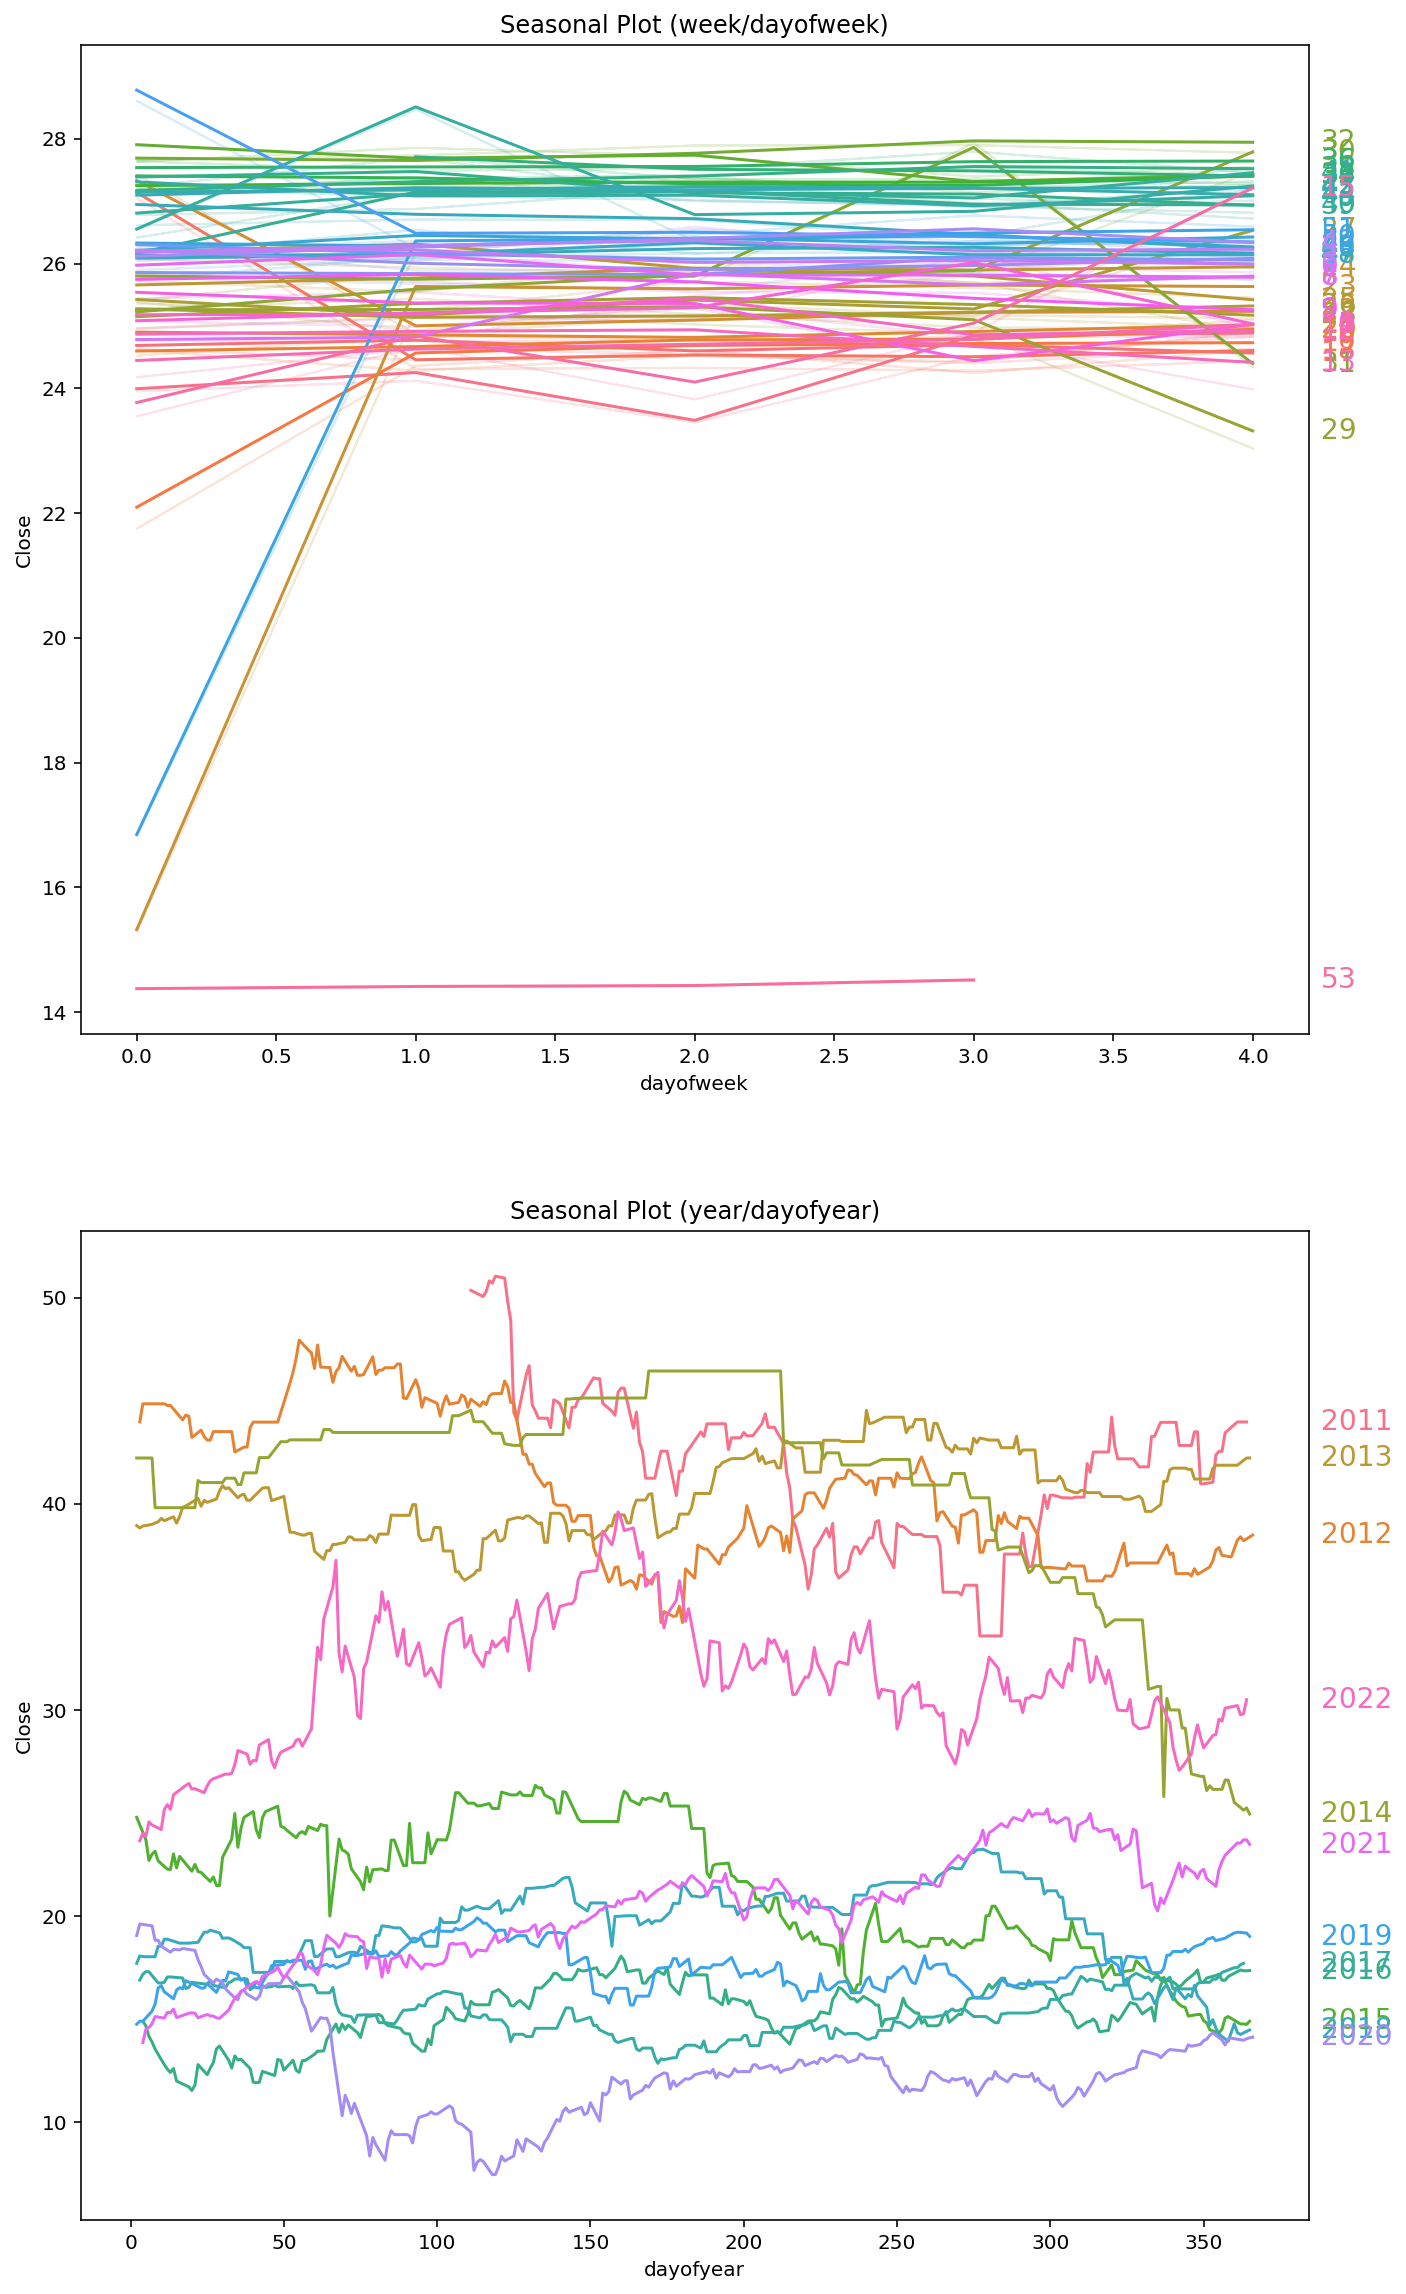

In [510]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 20))
seasonal_plot(dfc, y="Close", period="week", freq="dayofweek", ax=ax0)
seasonal_plot(dfc, y="Close", period="year", freq="dayofyear", ax=ax1);

<AxesSubplot:title={'center':'Seasonal Plot (year/week)'}, xlabel='week', ylabel='Close'>

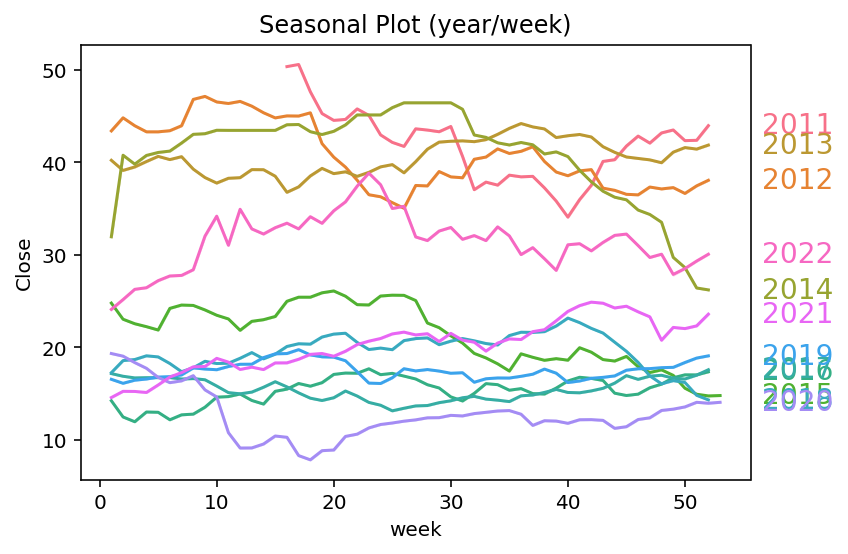

In [511]:
seasonal_plot(dfc, y="Close", period="year", freq="week")

<AxesSubplot:title={'center':'oil prices over the years'}, xlabel='Date'>

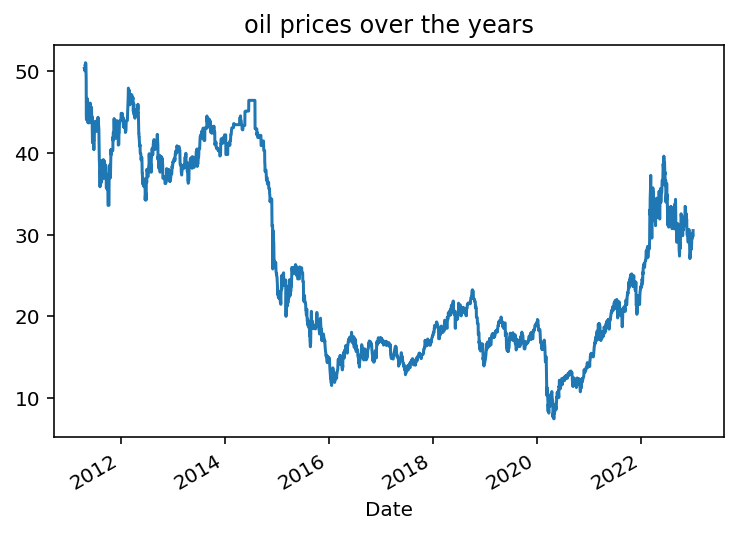

In [512]:
df.Close.plot(title = 'oil prices over the years')

In [513]:
from scipy.signal import periodogram
fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
freqencies, spectrum = periodogram(
        dfc.Close,
        fs=fs,
        detrend='linear',
        window="boxcar",
        scaling='spectrum',
    )

/Users/haritchowdhury/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  exec(code_obj, self.user_global_ns, self.user_ns)


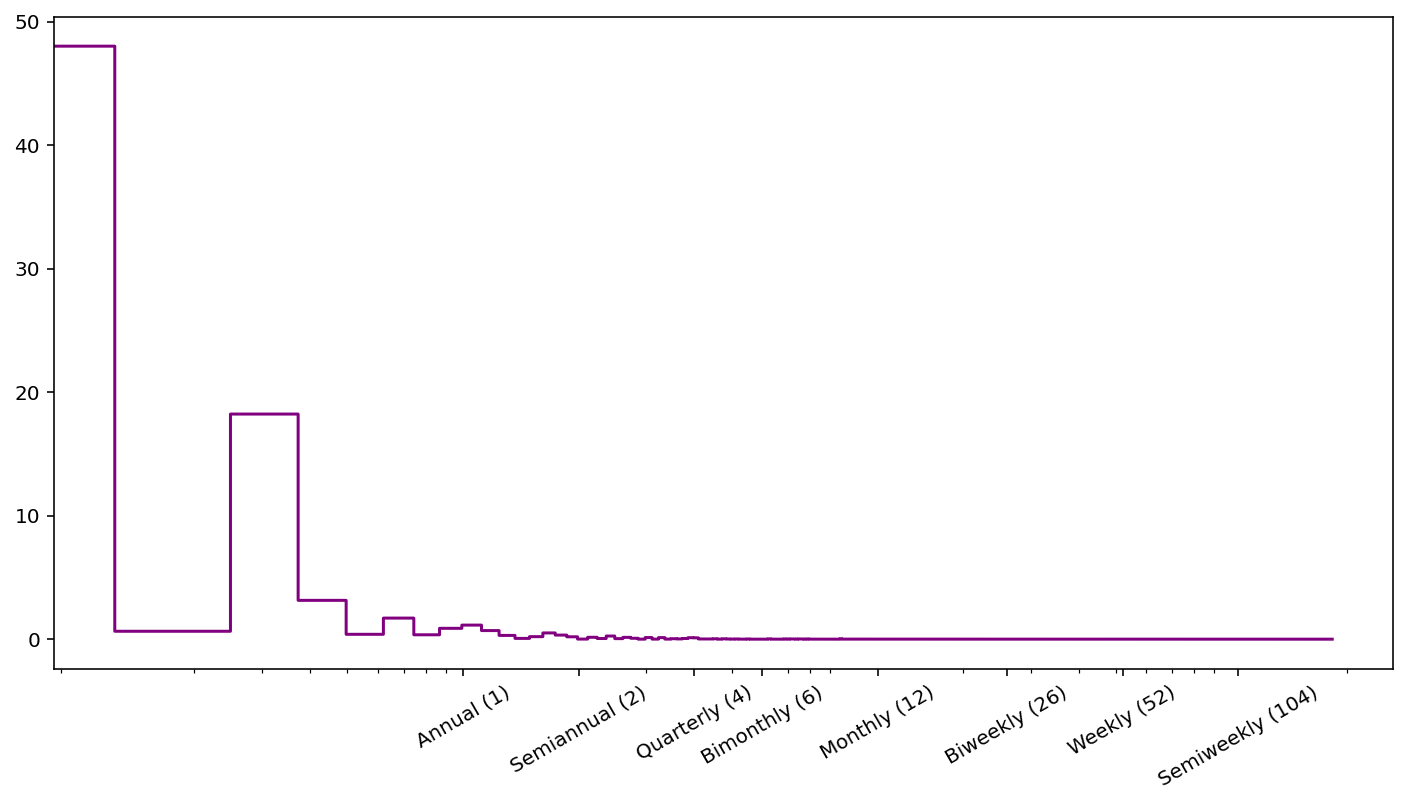

In [514]:
_, ax = plt.subplots(1, figsize = (12,6))
plt.step(freqencies, spectrum, color="purple")
ax.set_xscale("log")
ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
plt.show()

In [515]:
from statsmodels.tsa.deterministic import Fourier

index = date_range(end="2022-12-31", freq = 'D', periods=2944)

fourier = Fourier(period=365.25, order=10)

dp = DeterministicProcess( index, 
                           order=1, 
                           constant=True, 
                           seasonal=True, 
                           additional_terms=[fourier],
                           drop=True
                          )
dp.in_sample().head(3)

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,365.25)","cos(1,365.25)",...,"sin(6,365.25)","cos(6,365.25)","sin(7,365.25)","cos(7,365.25)","sin(8,365.25)","cos(8,365.25)","sin(9,365.25)","cos(9,365.25)","sin(10,365.25)","cos(10,365.25)"
2014-12-10,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2014-12-11,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017202,0.999852,...,0.103031,0.994678,0.120126,0.992759,0.137185,0.990545,0.154204,0.988039,0.171177,0.985240
2014-12-12,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034398,0.999408,...,0.204966,0.978769,0.238513,0.971139,0.271777,0.962360,0.304719,0.952442,0.337301,0.941397


In [516]:
X = dp.in_sample() 

# we can fill the nulls with 0s, if we are looking to build a lag indicator

# I am choosing to drop these

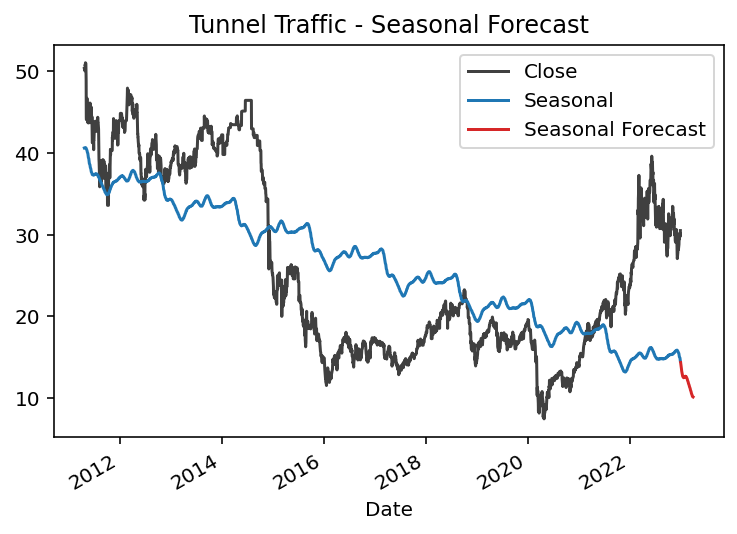

In [517]:
y = dfc['Close']

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

In [518]:
X.shape  # the model performs pretty flat

# because fourier series is only good for periodic data

# as we see from the periodogram, there is not much seasonality in the data.

(2944, 28)

In [519]:
from statsmodels.graphics.tsaplots import plot_pacf

/Users/haritchowdhury/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


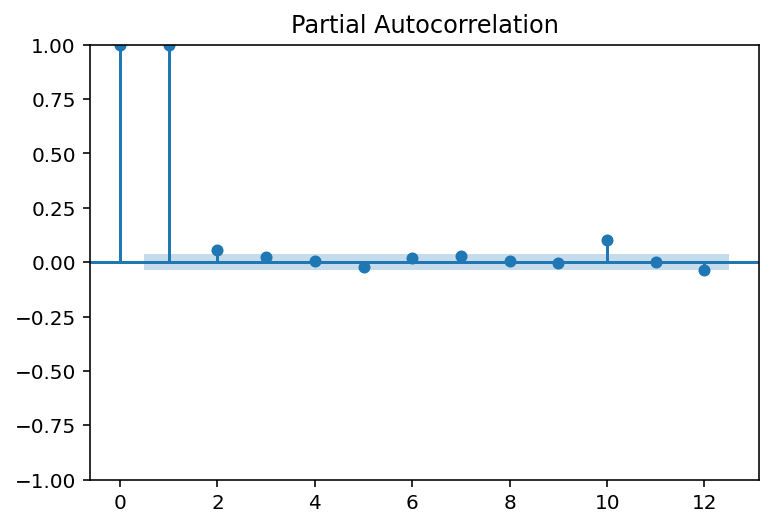

In [520]:
_ = plot_pacf(dfc.Close, lags=12)

## building a lag indicator using LinReg

In [521]:
def create_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


In [550]:
X1 = create_lags(dfc.Close, lags=21)
X1 = X1.fillna(0)

In [551]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [569]:
y = dfc.Close

X1_train, X1_test, y_train, y_test = train_test_split(X1[['y_lag_20', 'y_lag_21']], y, test_size=0.1, shuffle=False)

model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess

model.fit(X1_train, y_train)

y_pred1 = pd.Series(model.predict(X1_train), index=y_train.index)

y_fore1 = pd.Series(model.predict(X1_test), index=y_test.index)

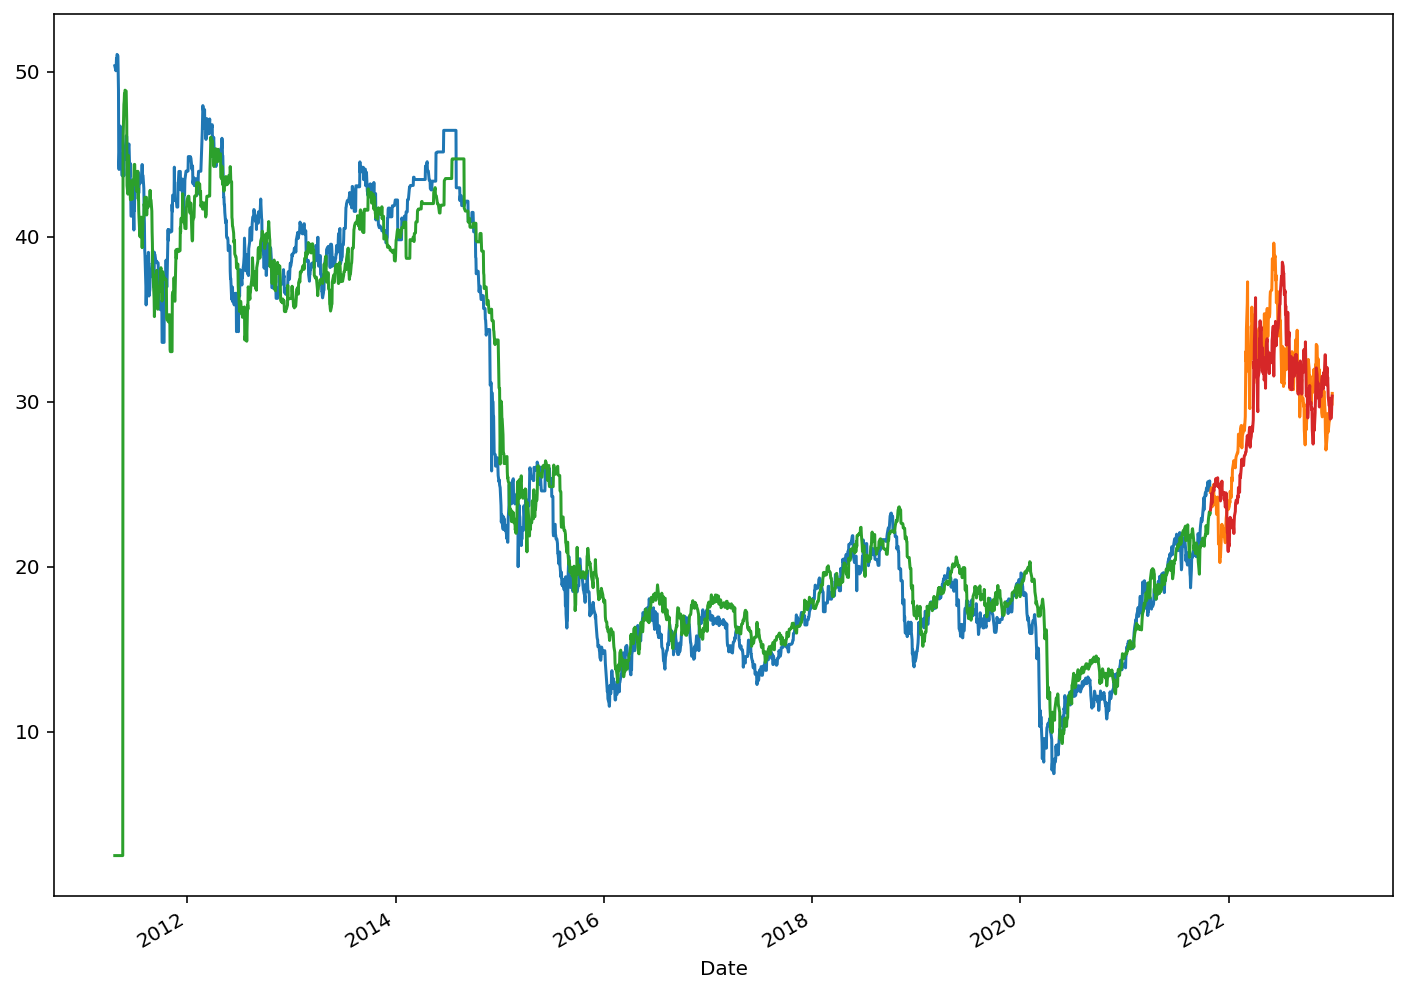

In [574]:
ax = y_train.plot(figsize = (12,9))
ax = y_test.plot()
ax = y_pred1.plot(ax=ax)
_ = y_fore1.plot(ax=ax, color='C3')

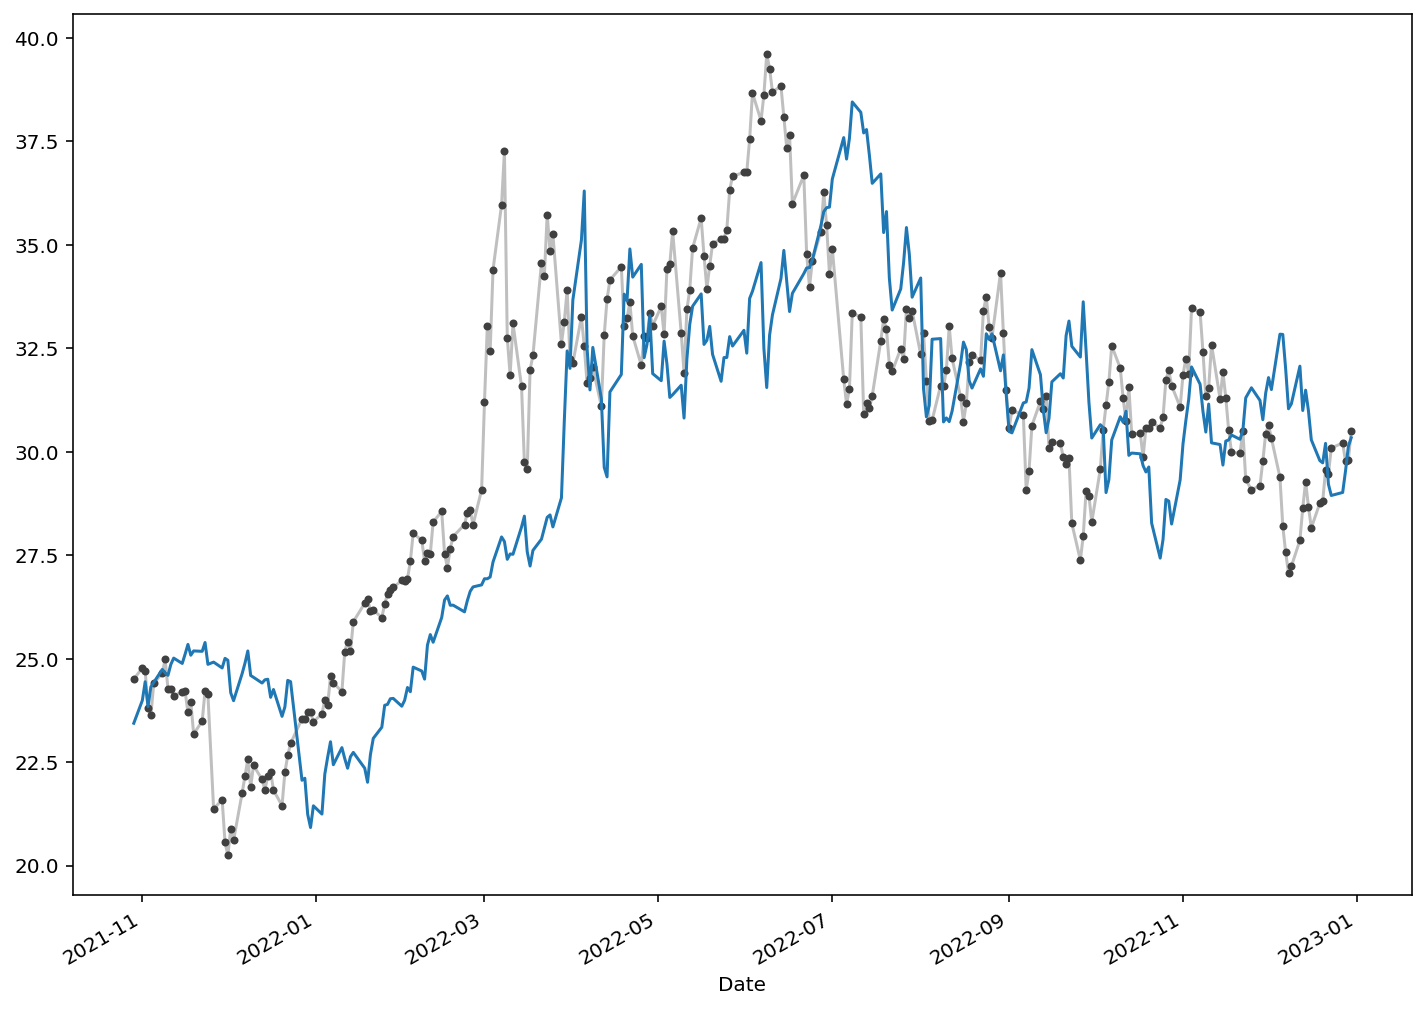

In [571]:
ax = y_test.plot(**plot_params, figsize = (12,9))
_ = y_fore1.plot(ax=ax, )

